# FIFA 랭킹과 본선 진출 라운드 상관관계
### 그전 3년 피파랭킹이나 포인트의 나라별 평균
- 1년에 한 데이터만 가져옴 (대체로 9월 업데이트 데이터) → 올해 가장 최근 업데이트 달에 맞춤

In [413]:
import numpy as np
import pandas as pd
import seaborn as sns
import glob

import warnings
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [414]:
font_path = 'C:\\Windows\\Fonts\\gulim.ttc'
font = fm.FontProperties(fname=font_path).get_name()
matplotlib.rc('font', family=font)
plt.rcParams['axes.unicode_minus'] = False

In [415]:
warnings.filterwarnings('ignore')

### 1. 데이터 로드

##### total_fifa_ranking.csv
- 1999년 부터 2005년 까지의 각 해 fifa_ranking 데이터를 합친 데이터 파일

In [416]:
files = glob.glob("./data/fifa_ranking_*.csv")

columns = ["rank","rank_change","team","total_points","previous_points","points_change","matches","update_date"]
ranking_list = []
for file in files:
    df = pd.read_csv(file, skiprows=1, names=columns)
    ranking_list.append(df)

merged_df = pd.concat(ranking_list, ignore_index=True)
merged_df.to_csv("data/total_fifa_ranking.csv")
merged_df.head()

,rank,rank_change,team,total_points,previous_points,points_change,matches,update_date
0,1,,Brazil,838.0,842.0,-4,-,1999-09-15
1,2,1,Czech Republic,772.0,753.0,+19,-,1999-09-15
2,3,1,France,766.0,755.0,+11,-,1999-09-15
3,4,3,Spain,757.0,713.0,+44,-,1999-09-15
4,5,,Germany,735.0,718.0,+17,-,1999-09-15


##### 사용할 컬럼

| 컬럼명 | 컬럼 설명 |
| --- | --- |
| rank | 업데이트일 기준 FIFA랭킹 순위 (1위가 가장 높음) |
| rank_change | 순위 변동 폭 (양수: 상승 / 음수: 하락) |
| team | 국가명  |
| total_points | 업데이트일 기준 FIFA 랭킹 포인트 (경기 결과·대회 중요도·상대 전적 등을 가중치로 계산) |
| previous_points | 이전 업데이트 기준 포인트 |
| points_change | 포인트 증감률 (양수: 증가 / 음수: 감소) |
| matches | 랭킹 산출에 사용된 경기 결과 요약 (최근 거만 있음) |
| update_date | FIFA 랭킹 업데이트일 (YYYY-MM-DD)  |

### 2. 데이터 구조 및 기초 통계 확인

In [417]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5617 entries, 0 to 5616
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rank             5617 non-null   int64  
 1   rank_change      4356 non-null   object 
 2   team             5617 non-null   object 
 3   total_points     5617 non-null   float64
 4   previous_points  5617 non-null   float64
 5   points_change    5616 non-null   object 
 6   matches          2262 non-null   object 
 7   update_date      5617 non-null   object 
dtypes: float64(2), int64(1), object(5)
memory usage: 351.2+ KB


In [418]:
merged_df.describe()

,rank,total_points,previous_points
count,5617.000000,5617.000000,5617.000000
mean,103.765889,647.388912,646.208636
std,59.987373,472.965532,473.392033
min,1.000000,0.000000,0.000000
25%,52.000000,245.000000,242.000000
50%,104.000000,539.000000,539.000000
75%,156.000000,1032.000000,1027.120000
max,211.000000,1889.020000,1901.480000


### 3. 결측치 및 이상치 탐색

In [419]:
# 결측치 탐색
merged_df.isnull().sum()

rank                  0
rank_change        1261
team                  0
total_points          0
previous_points       0
points_change         1
matches            3355
update_date           0
dtype: int64

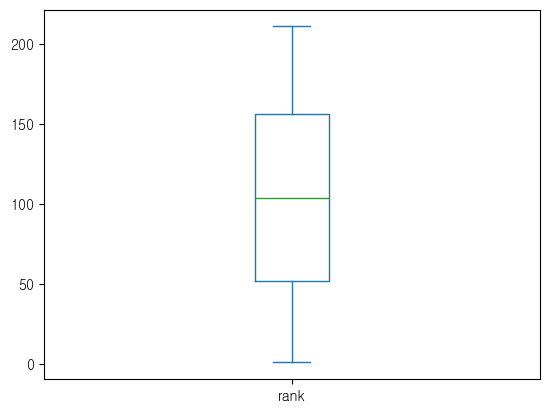

,rank,rank_change,team,total_points,previous_points,points_change,matches,update_date


In [420]:
# 이상치 탐색
merged_df['rank'].plot(kind='box')
plt.show()

merged_df[merged_df['rank'] < 0]

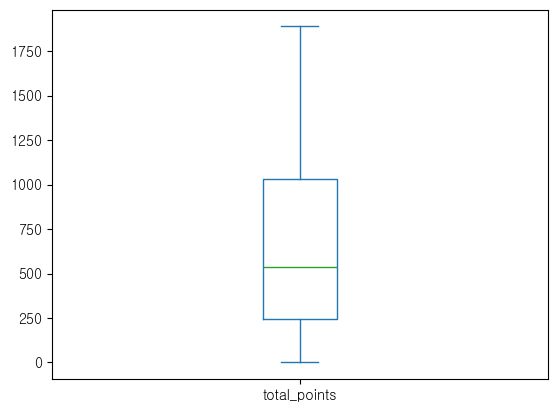

,rank,rank_change,team,total_points,previous_points,points_change,matches,update_date


In [421]:
# 이상치 탐색
merged_df['total_points'].plot(kind='box')
plt.show()

merged_df[merged_df['total_points'] < 0]

### 4. 데이터 시각화를 통한 탐색

In [422]:
merged_df["update_date"] = pd.to_datetime(merged_df["update_date"])
merged_df["year"] = merged_df["update_date"].dt.year.astype(int)

#### 상관관계

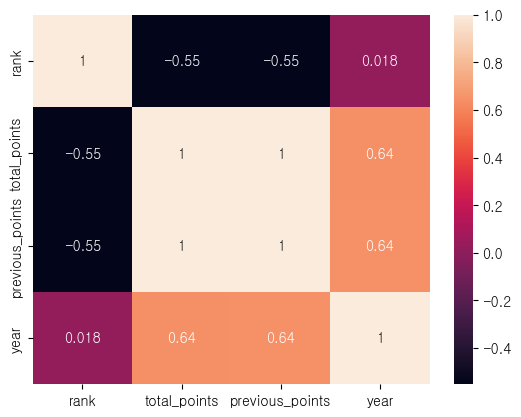

In [423]:
corr_matrix = merged_df.corr(numeric_only=True)
corr_matrix

sns.heatmap(corr_matrix, annot=True)
plt.show()

#### 가장 최근 FIFA 포인트 상위 국가

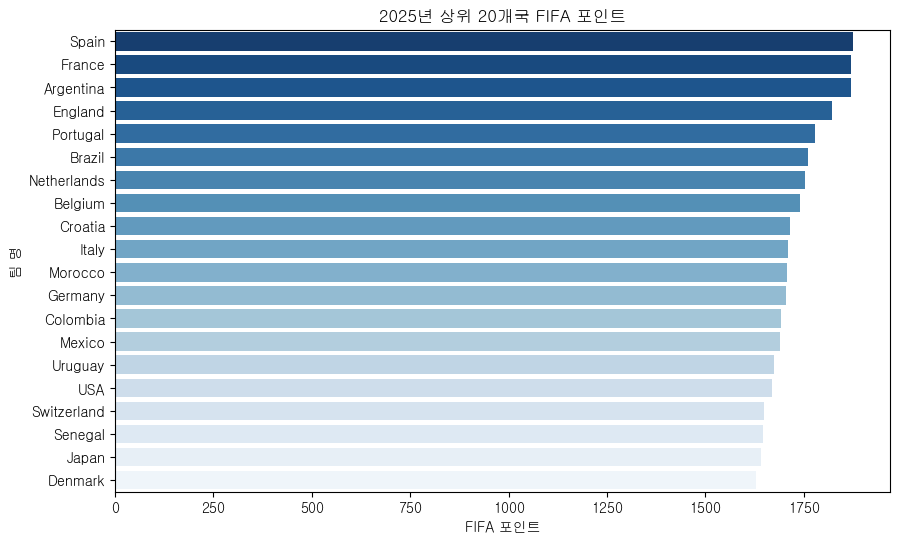

In [424]:
latest_year = merged_df['year'].max()
top20 = (merged_df[merged_df["year"]==latest_year]
         .sort_values('total_points', ascending=False)
         .head(20))

plt.figure(figsize=(10,6))
sns.barplot(data=top20, x='total_points', y='team', palette='Blues_r')
plt.title(f"{latest_year}년 상위 20개국 FIFA 포인트")
plt.xlabel("FIFA 포인트")
plt.ylabel("팀 명")
plt.show()


#### 국가별 월드컵 개최 전 3년 평균 FIFA 랭킹 (개최 연도별)

In [425]:
wc_years = [2002, 2006, 2010, 2014, 2018, 2022, 2026]

wc_avg_list = []
for year in wc_years:
    pre_years = list(range(year-3, year))
    sub_df = merged_df[merged_df['year'].isin(pre_years)]
    
    avg_rank = sub_df.groupby('team')['rank'].mean().reset_index()
    avg_rank['wc_year'] = year
    
    wc_avg_list.append(avg_rank)

avg_rank_df = pd.concat(wc_avg_list, ignore_index=True)
avg_rank_df[avg_rank_df['wc_year']==2022].sort_values('rank', ascending=True)

,team,rank,wc_year
1054,Belgium,1.000000,2022
1063,Brazil,2.666667,2022
1110,France,2.666667,2022
1100,England,3.666667,2022
1197,Portugal,5.666667,2022
...,...,...,...
1049,Bahamas,202.000000,2022
1248,US Virgin Islands,204.000000,2022
1064,British Virgin Islands,205.500000,2022
1102,Eritrea,206.000000,2022


In [426]:
avg_rank_df[avg_rank_df['team']=='Brazil']

,team,rank,wc_year
26,Brazil,1.333333,2002
230,Brazil,1.000000,2006
434,Brazil,3.333333,2010
642,Brazil,9.000000,2014
851,Brazil,4.000000,2018
1063,Brazil,2.666667,2022
1289,Brazil,4.666667,2026


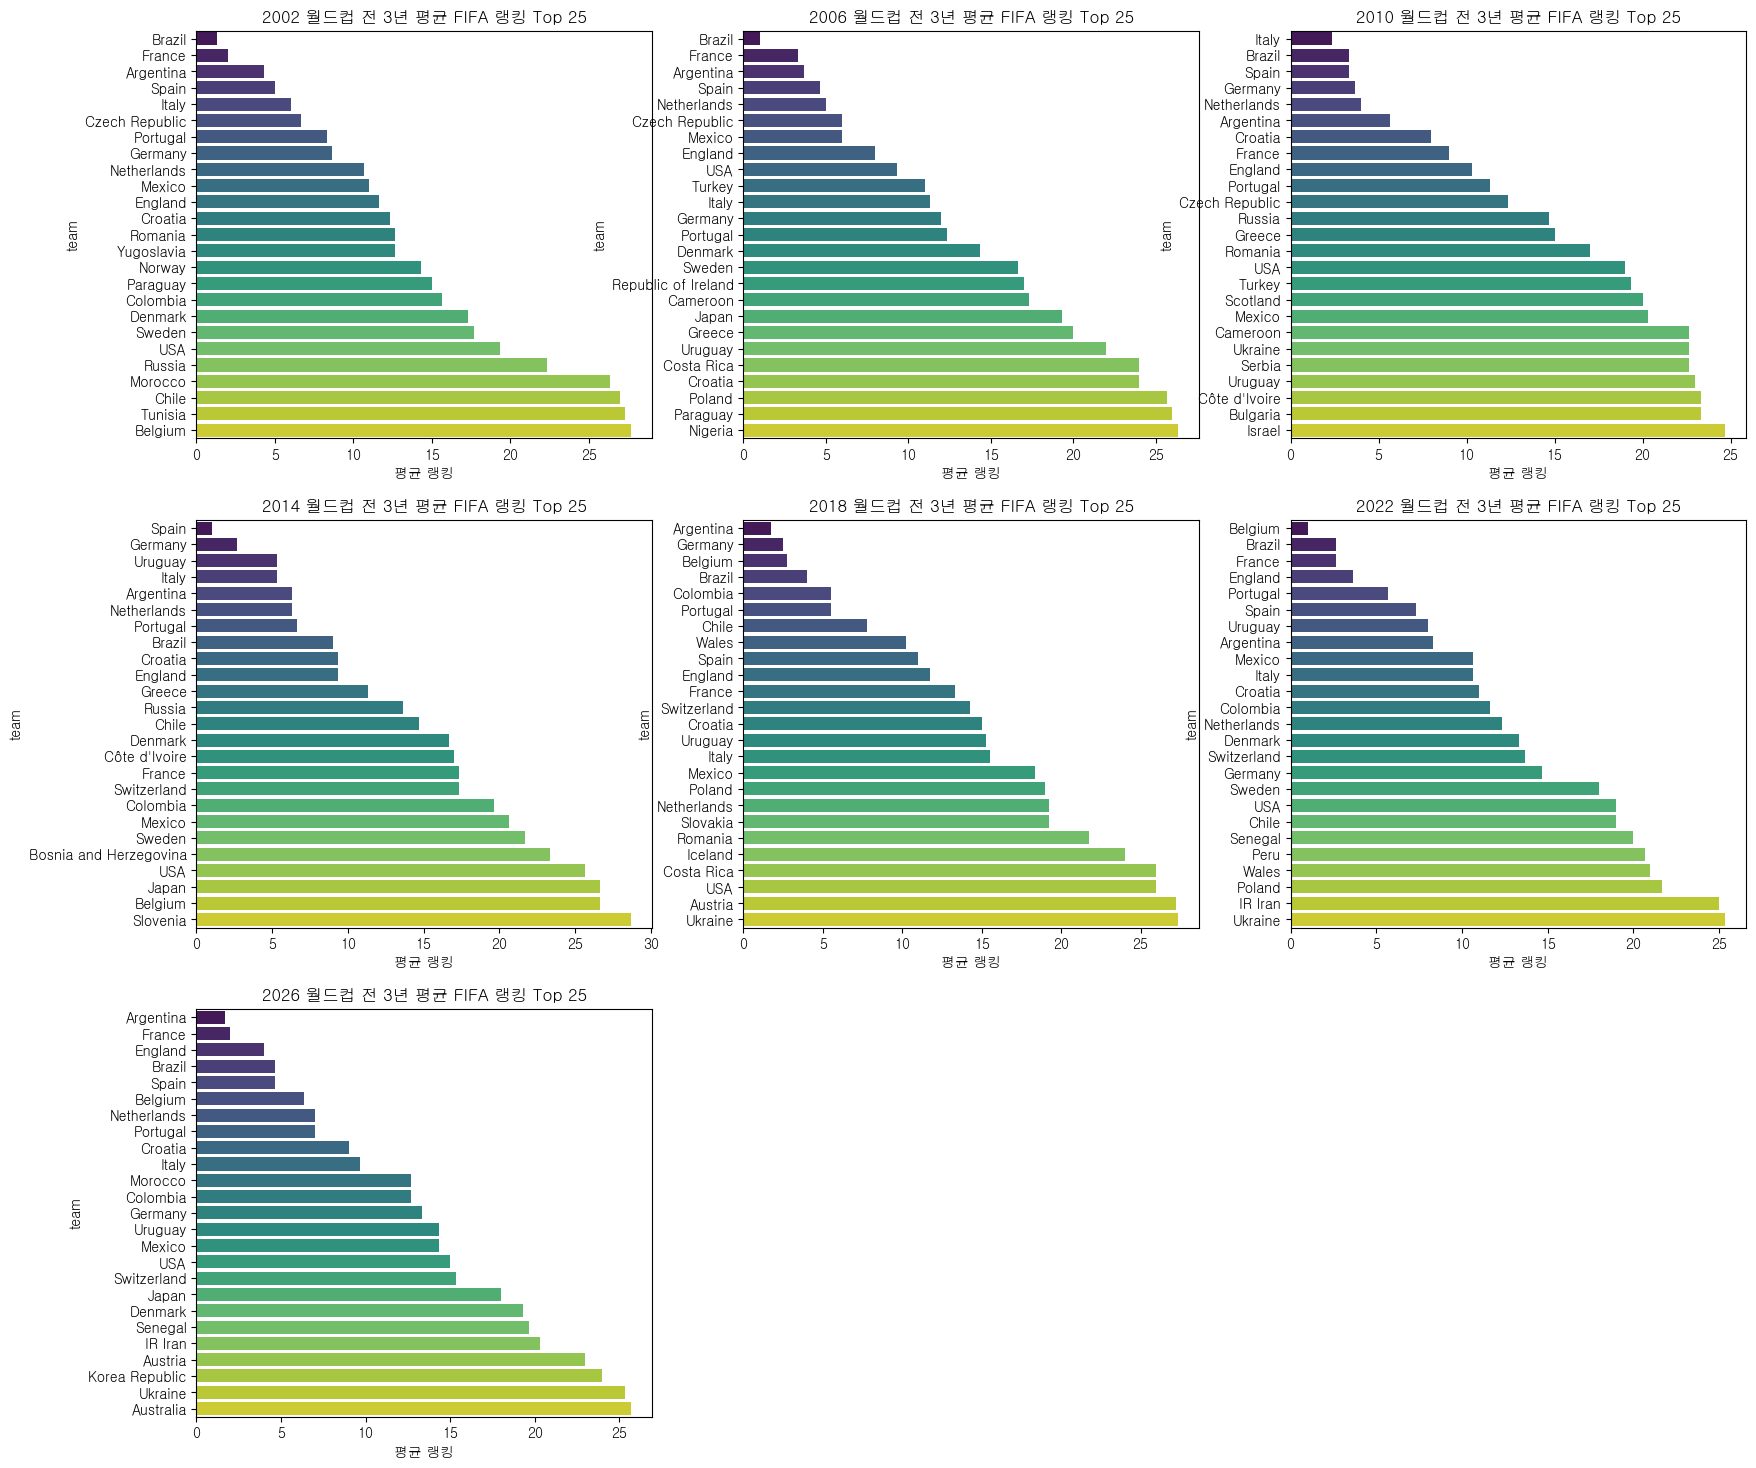

In [427]:
wc_years = sorted(avg_rank_df["wc_year"].unique())

plt.figure(figsize=(20,18))
for i, year in enumerate(wc_years, start=1):
    plt.subplot(3, 3, i)
    top25 = (avg_rank_df[avg_rank_df["wc_year"] == year].sort_values("rank").head(25))

    sns.barplot(data=top25,x="rank",y="team",palette="viridis")
    
    plt.title(f"{year} 월드컵 전 3년 평균 FIFA 랭킹 Top 25")
    plt.xlabel("평균 랭킹")

plt.show()

#### 국가별 월드컵 개최 전 3년 총 평균 FIFA 랭킹

In [428]:
total_avg_rank_df = merged_df.groupby('team')['rank'].mean().reset_index(name='total_avg_rank')
total_avg_rank_df = total_avg_rank_df.sort_values(by='total_avg_rank', ascending=True)
total_avg_rank_df['wc_year'] = year
total_avg_rank_df

,team,total_avg_rank,wc_year
28,Brazil,3.500000,2026
8,Argentina,4.500000,2026
193,Spain,5.714286,2026
78,France,7.185185,2026
82,Germany,7.750000,2026
...,...,...,...
223,Turks and Caicos Islands,194.714286,2026
190,Somalia,194.923077,2026
225,US Virgin Islands,195.307692,2026
84,Gibraltar,199.777778,2026


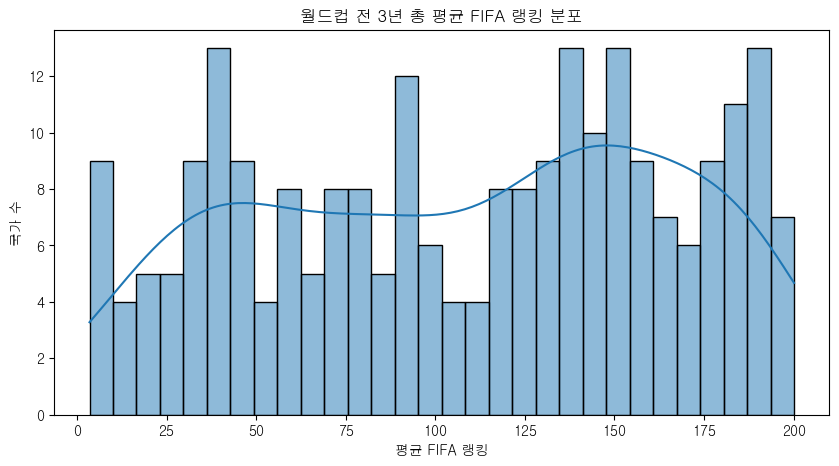

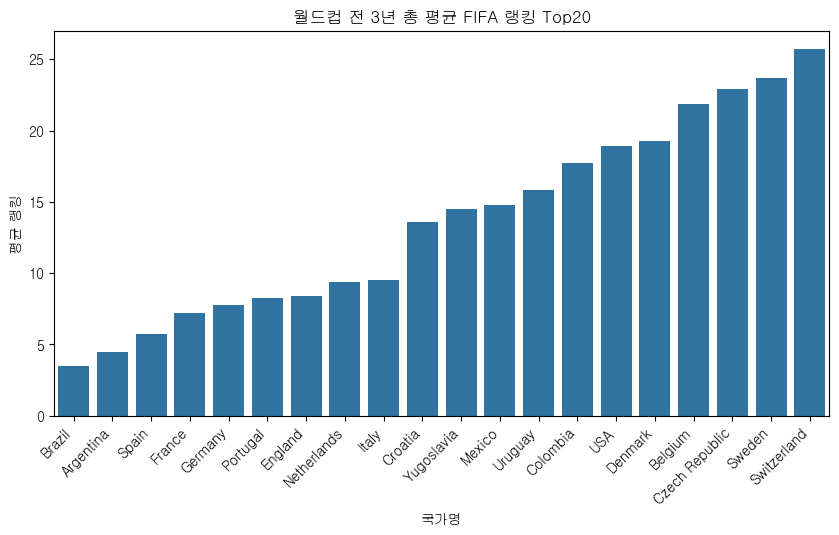

In [429]:
plt.figure(figsize=(10,5))
sns.histplot(total_avg_rank_df['total_avg_rank'], bins=30, kde=True)
plt.title("월드컵 전 3년 총 평균 FIFA 랭킹 분포")
plt.xlabel("평균 FIFA 랭킹")
plt.ylabel("국가 수")
plt.show()

plt.figure(figsize=(10,5))
sns.barplot(total_avg_rank_df.head(20), x='team', y='total_avg_rank')
plt.xticks(rotation=45, ha='right')
plt.title("월드컵 전 3년 총 평균 FIFA 랭킹 Top20")
plt.xlabel("국가명")
plt.ylabel("평균 랭킹")
plt.show()

#### 총 평균 FIFA 랭킹 기준 상위 4팀의 추세

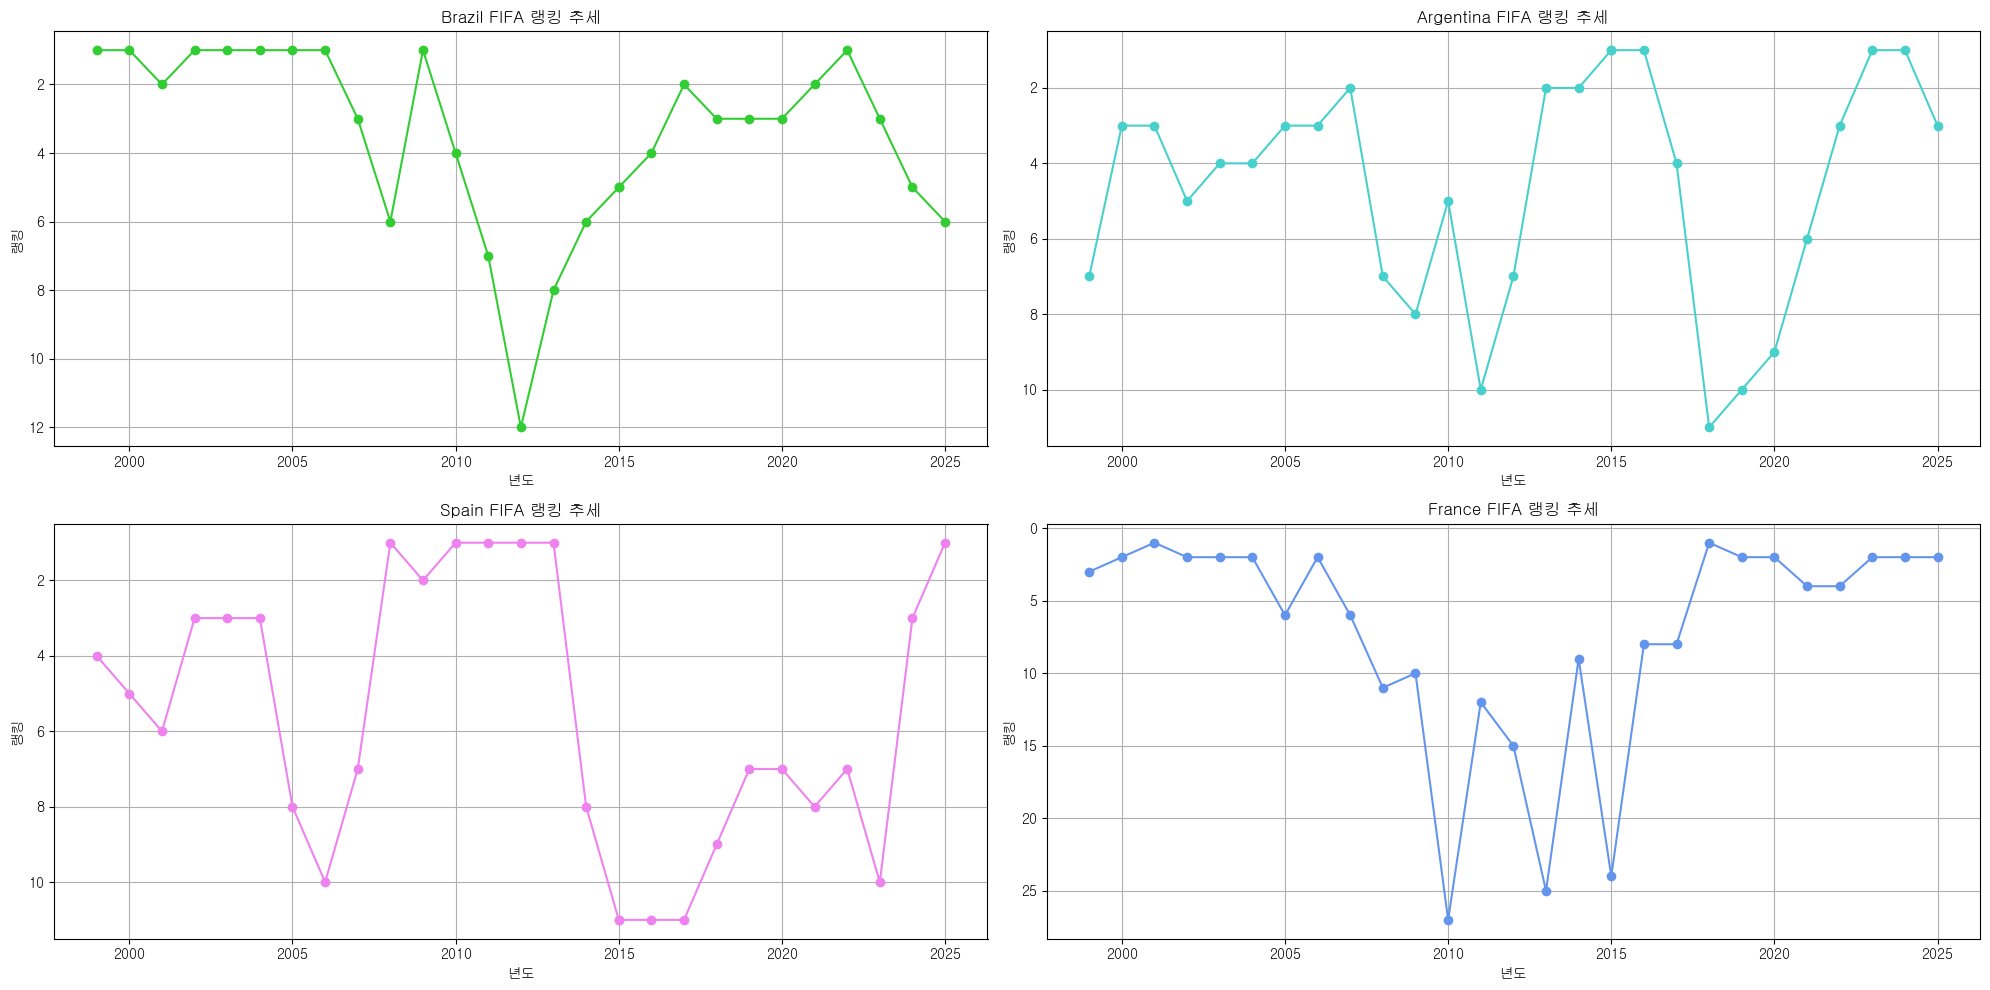

In [430]:
top4_teams = total_avg_rank_df['team'].head(4).tolist()
colors = ['limegreen', 'mediumturquoise', 'violet', 'cornflowerblue']

fig, ax = plt.subplots(figsize=(20, 10), ncols=2, nrows=2)
ax = ax.flatten()

for i, team in enumerate(top4_teams):
    team_hist = merged_df[merged_df["team"] == team]

    ax[i].plot(team_hist["year"], team_hist["rank"],marker="o", color=colors[i])

    ax[i].set_title(f"{team} FIFA 랭킹 추세")
    ax[i].set_xlabel("년도")
    ax[i].set_ylabel("랭킹")
    ax[i].invert_yaxis() 
    ax[i].grid(True)

plt.tight_layout()
plt.show()


#### 국가별 월드컵 개최 전 3년 평균 FIFA 포인트 (개최 연도별)

In [431]:
wc_years = [2002, 2006, 2010, 2014, 2018, 2022, 2026]

wc_avg_list = []
for year in wc_years:
    pre_years = list(range(year-3, year))
    sub_df = merged_df[merged_df['year'].isin(pre_years)]
    
    avg_points = sub_df.groupby('team')['total_points'].mean().reset_index()
    avg_points['wc_year'] = year
    
    wc_avg_list.append(avg_points)

avg_points_df = pd.concat(wc_avg_list, ignore_index=True)
avg_points_df[avg_points_df['wc_year']==2022].sort_values('total_points', ascending=False)

,team,total_points,wc_year
1054,Belgium,1785.776667,2022
1063,Brazil,1747.576667,2022
1110,France,1741.103333,2022
1100,England,1693.813333,2022
1197,Portugal,1656.966667,2022
...,...,...,...
1188,Pakistan,867.000000,2022
1248,US Virgin Islands,859.500000,2022
1102,Eritrea,856.000000,2022
1064,British Virgin Islands,854.500000,2022


In [432]:
avg_points_df[avg_points_df['team']=='Brazil']

,team,total_points,wc_year
26,Brazil,818.333333,2002
230,Brazil,847.333333,2006
434,Brazil,1433.333333,2010
642,Brazil,1065.000000,2014
851,Brazil,1332.750000,2018
1063,Brazil,1747.576667,2022
1289,Brazil,1790.410000,2026


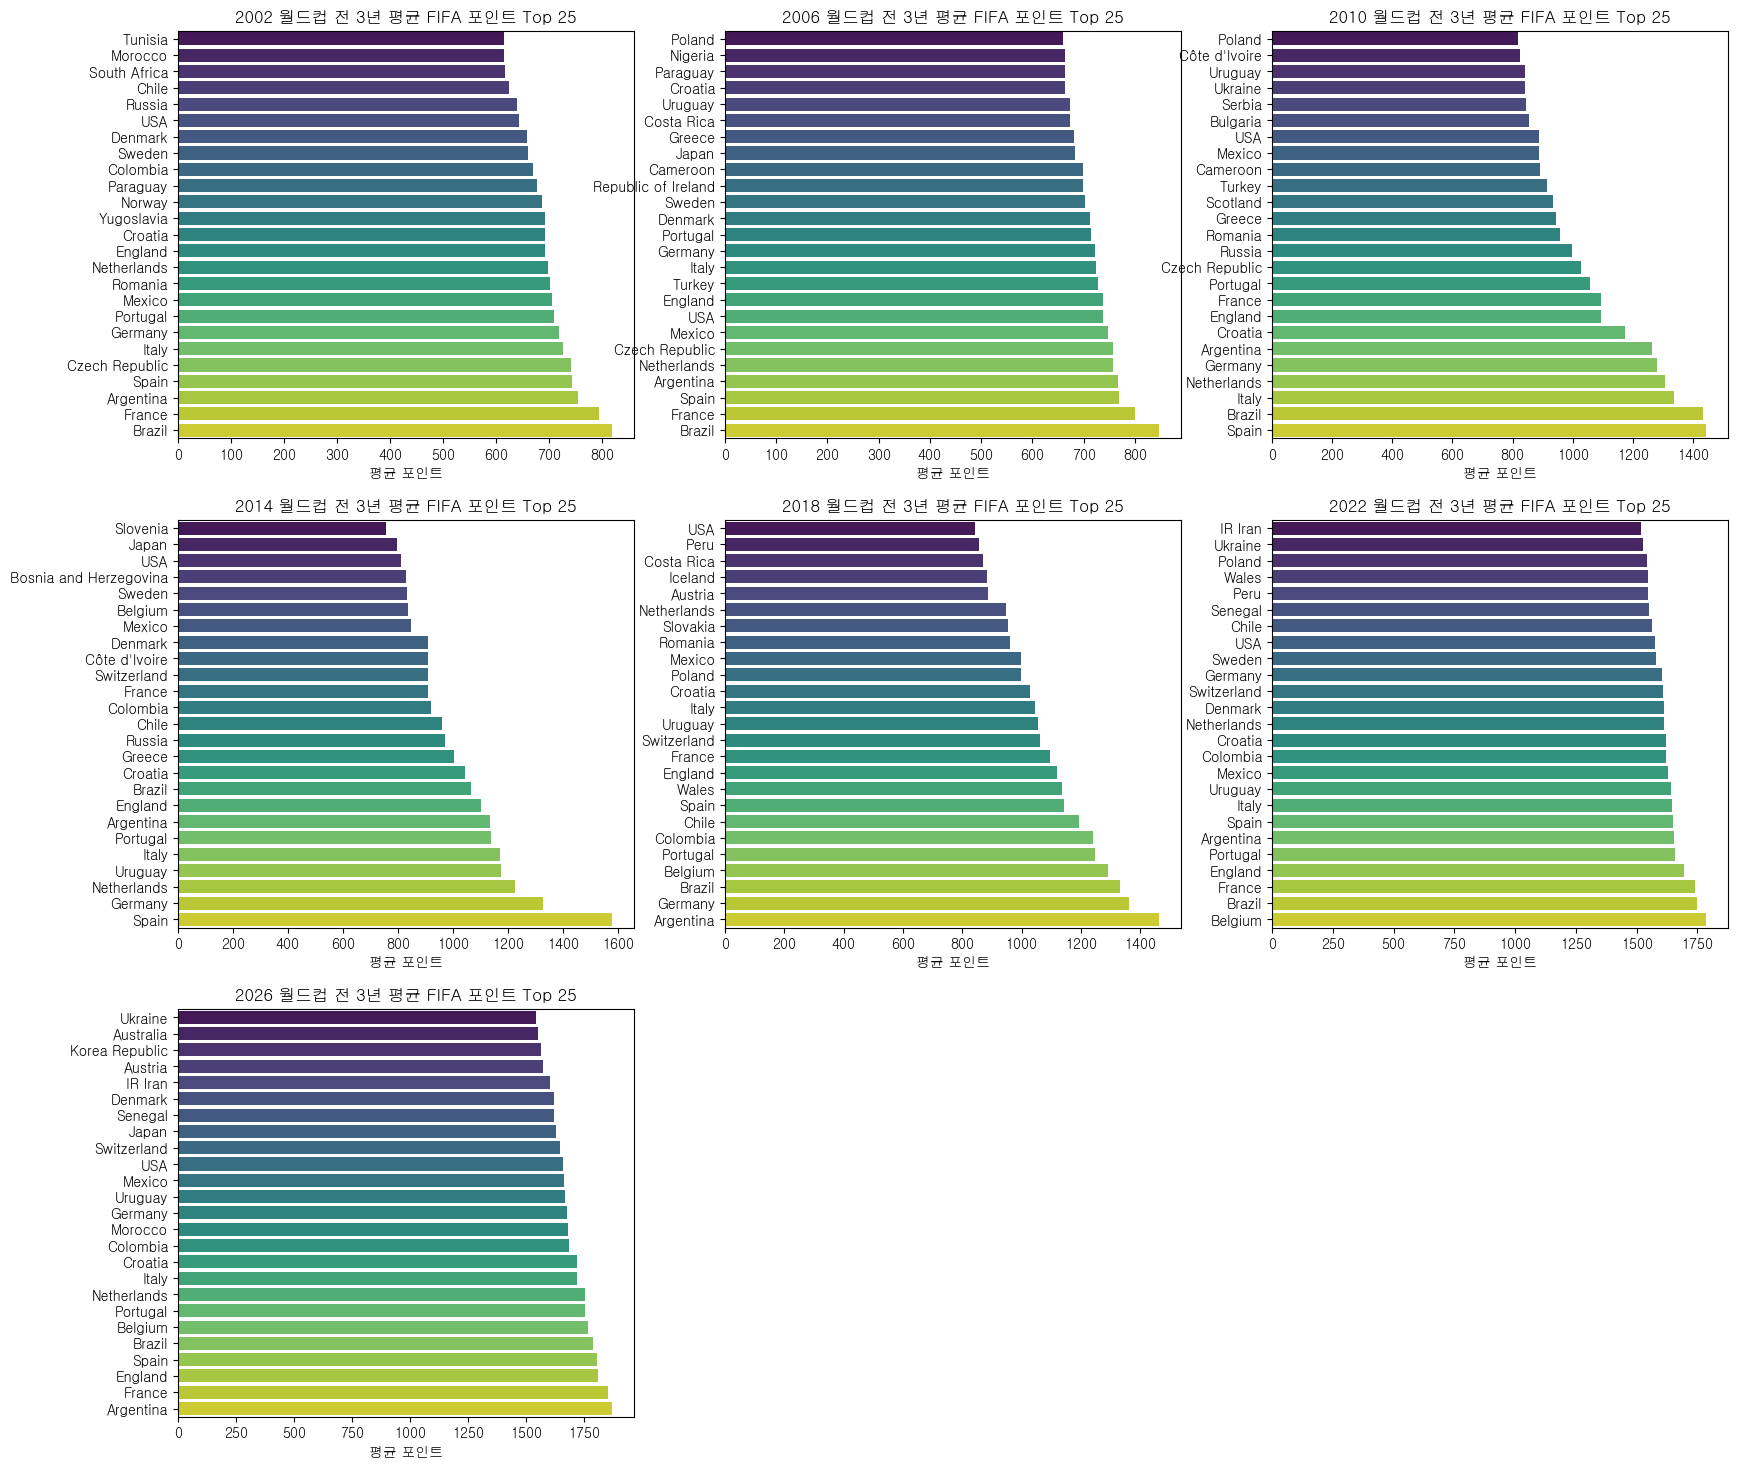

In [433]:
wc_years = sorted(avg_points_df["wc_year"].unique())

plt.figure(figsize=(20,18))
for i, year in enumerate(wc_years, start=1):
    plt.subplot(3, 3, i)
    top25 = (avg_points_df[avg_points_df["wc_year"] == year].sort_values("total_points").tail(25))

    sns.barplot(data=top25,x="total_points",y="team",palette="viridis")
    
    plt.title(f"{year} 월드컵 전 3년 평균 FIFA 포인트 Top 25")
    plt.xlabel("평균 포인트")
    plt.ylabel("")

plt.show()

#### 국가별 월드컵 개최 전 3년 총 평균 FIFA 포인트

In [434]:
total_avg_points_df = merged_df.groupby('team')['total_points'].mean().reset_index(name='total_avg_points')
total_avg_points_df = total_avg_points_df.sort_values(by='total_avg_points', ascending=False)
total_avg_points_df['wc_year'] = year
total_avg_points_df

,team,total_avg_points,wc_year
224,Türkiye,1507.445000,2026
58,Czechia,1491.532500,2026
153,North Macedonia,1356.658571,2026
35,Cabo Verde,1341.318333,2026
28,Brazil,1326.366429,2026
...,...,...,...
177,San Marino,241.674615,2026
50,Cook Islands,227.863333,2026
205,Swaziland,226.916667,2026
178,Sao Tome e Principe,150.190476,2026


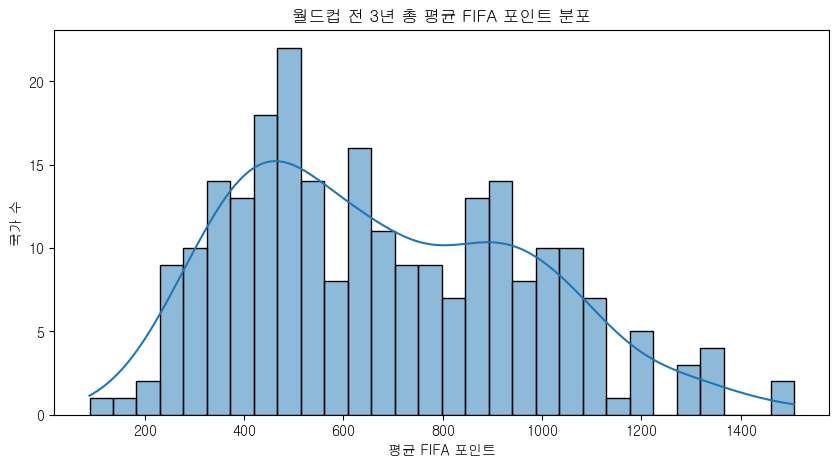

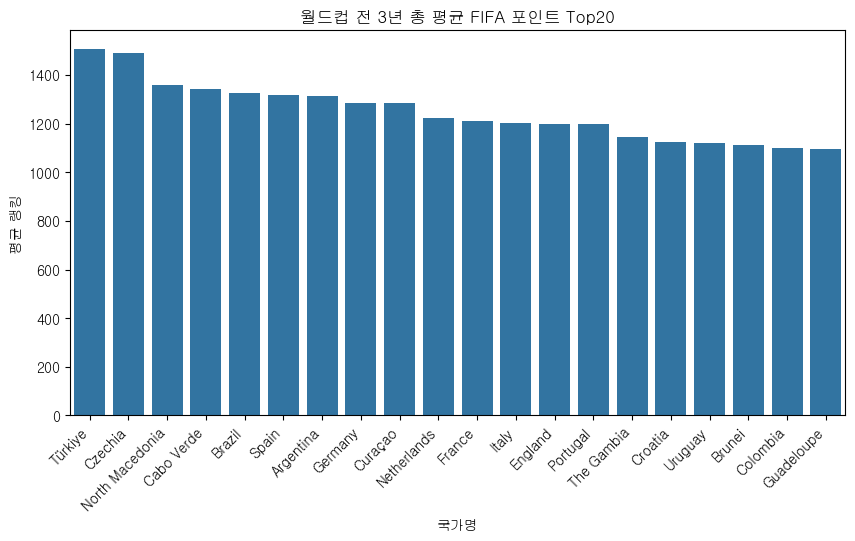

In [435]:
plt.figure(figsize=(10,5))
sns.histplot(total_avg_points_df['total_avg_points'], bins=30, kde=True)
plt.title("월드컵 전 3년 총 평균 FIFA 포인트 분포")
plt.xlabel("평균 FIFA 포인트")
plt.ylabel("국가 수")
plt.show()

plt.figure(figsize=(10,5))
sns.barplot(total_avg_points_df.head(20), x='team', y='total_avg_points')
plt.xticks(rotation=45, ha='right')
plt.title("월드컵 전 3년 총 평균 FIFA 포인트 Top20")
plt.xlabel("국가명")
plt.ylabel("평균 랭킹")
plt.show()

---

### 5. 데이터 정제 및 전처리

In [436]:
# 전처리 함수
def change_type(df):
    df["update_date"] = pd.to_datetime(df["update_date"])
    df["year"] = df["update_date"].dt.year.astype(int)
    return df

def create_feature(df):
    df = df.sort_values(['team', 'wc_year']).reset_index(drop=True)
    
    df['rank_diff'] = None
    df['points_diff'] = None

    teams = df['team'].unique()
    for team in teams:
        team_df = df[df['team'] == team]
        for idx, row in team_df.iterrows():
            prev_wc_year = row['wc_year'] - 4
            prev_row = team_df[team_df['wc_year'] == prev_wc_year]
            if not prev_row.empty:
                df.loc[idx, 'rank_diff'] = round(row['rank'] - prev_row['rank'].values[0], 2)
                df.loc[idx, 'points_diff'] = round(row['total_points'] - prev_row['total_points'].values[0], 2)
    
    return df

def drop_feature(df, columns):
    return df.drop(columns=columns, axis=1)


In [437]:
cols_to_drop = ["rank_change","previous_points","points_change","matches", "update_date"]

# 전처리 함수 호출
def preprocessing(df):
    df = change_type(df)
    df = drop_feature(df, cols_to_drop)
    return df

df = preprocessing(merged_df)
df['wc_year'] = year
df

,rank,team,total_points,year,wc_year
0,1,Brazil,838.00,1999,2026
1,2,Czech Republic,772.00,1999,2026
2,3,France,766.00,1999,2026
3,4,Spain,757.00,1999,2026
4,5,Germany,735.00,1999,2026
...,...,...,...,...,...
5612,203,Seychelles,812.32,2025,2026
5613,204,Liechtenstein,808.48,2025,2026
5614,205,Bahamas,807.36,2025,2026
5615,206,Turks and Caicos Islands,803.98,2025,2026


In [438]:
avg_rank_df

,team,rank,wc_year
0,Albania,88.000000,2002
1,Algeria,77.333333,2002
2,American Samoa,200.333333,2002
3,Andorra,147.000000,2002
4,Angola,54.000000,2002
...,...,...,...
1467,Vietnam,108.333333,2026
1468,Wales,30.666667,2026
1469,Yemen,155.000000,2026
1470,Zambia,86.666667,2026


In [439]:
avg_points_df

,team,total_points,wc_year
0,Albania,441.333333,2002
1,Algeria,470.333333,2002
2,American Samoa,10.000000,2002
3,Andorra,225.000000,2002
4,Angola,535.333333,2002
...,...,...,...
1467,Vietnam,1191.480000,2026
1468,Wales,1522.046667,2026
1469,Yemen,1020.953333,2026
1470,Zambia,1271.806667,2026


##### 월드컵 전 3년 평균 랭킹 및 포인트 데이터셋 저장 (월드컵 개최 연도 별)
- avg_rank_points.csv

In [440]:
avg_rank_df['rank'] = avg_rank_df['rank'].round(2)
avg_points_df['total_points'] = avg_points_df['total_points'].round(2)

merged_avg_df = pd.merge(avg_rank_df, avg_points_df, left_on=['team', 'wc_year'], right_on=['team', 'wc_year'], how='inner')
merged_avg_df = create_feature(merged_avg_df)

total_avg_df = merged_avg_df.to_csv("data/avg_rank_points.csv", index=False)
total_avg_df

##### 월드컵 전 3년 평균 랭킹 및 포인트 데이터셋 저장 (총합)
- total_avg_rank_points.csv

In [441]:
avg_rank_df = df.groupby('team')['rank'].mean().reset_index(name='avg_rank')
avg_points_df = df.groupby('team')['total_points'].mean().reset_index(name='avg_points')
merged_avg_df = pd.merge(avg_rank_df, avg_points_df, on='team', how='inner')

total_avg_df = merged_avg_df.to_csv("data/total_avg_rank_points.csv", index=False)
total_avg_df